# Topic modeling

The [topicmod module](api.rst#module-tmtoolkit.topicmod) offers a wide range of tools to facilitate [topic modeling](https://cacm.acm.org/magazines/2012/4/147361-probabilistic-topic-models/fulltext) with Python. This chapter will introduce the following techniques: 

TODO (link this)
TODO model convergence

- [parallel topic model computation for different copora and/or parameter sets](#Computing-topic-models-in-parallel)
- evaluation of topic models (including finding the "optimal" number of topics)
- common statistics for topic models
- export of topic models and summaries to different file formats
- visualization of topic models

## An example document-term matrix

tmtoolkit supports topic models that are computed from document-term matrices (DTMs). Just as in the previous chapter, we will at first generate a DTM. However, this time the sample will be bigger:

In [1]:
import random
random.seed(20191120)   # to make the sampling reproducible

import numpy as np
np.set_printoptions(precision=5)

from tmtoolkit.corpus import Corpus

corpus = Corpus.from_builtin_corpus('english-NewsArticles').sample(100)

We will also now generate two DTMs, because we later want to show how you can compute topic models for two different DTMs in parallel. At first, we to some general preprocessing:

In [2]:
from tmtoolkit.preprocess import TMPreproc

preproc = TMPreproc(corpus)
preproc.pos_tag() \
    .lemmatize() \
    .tokens_to_lowercase() \
    .remove_special_chars_in_tokens()

<TMPreproc [100 documents]>

Now we at first apply more "relaxed" cleaning:

In [3]:
preproc_bigger = preproc.copy() \
    .clean_tokens(remove_shorter_than=2) \
    .remove_common_tokens(df_threshold=0.95) \
    .remove_uncommon_tokens(df_threshold=0.05)

preproc_bigger.n_docs, preproc_bigger.vocabulary_size

(100, 846)

Another copy of `preproc` will apply more aggressive cleaning and hence in a smaller vocabulary size:

In [4]:
preproc_smaller = preproc.copy() \
    .filter_for_pos('N') \
    .clean_tokens(remove_numbers=True, remove_shorter_than=2) \
    .remove_common_tokens(df_threshold=0.9) \
    .remove_uncommon_tokens(df_threshold=0.1)

del preproc

preproc_smaller.n_docs, preproc_smaller.vocabulary_size

(100, 149)

We will create the document labels, vocabulary arrays and DTMs for both versions now:

In [5]:
# doc_labels are the same for both

doc_labels = np.array(preproc_bigger.doc_labels)
doc_labels[:10]

array(['NewsArticles-1032', 'NewsArticles-1036', 'NewsArticles-104',
       'NewsArticles-1043', 'NewsArticles-1048', 'NewsArticles-1090',
       'NewsArticles-1126', 'NewsArticles-113', 'NewsArticles-1137',
       'NewsArticles-1141'], dtype='<U17')

In [6]:
vocab_bg = np.array(preproc_bigger.vocabulary)
vocab_sm = np.array(preproc_smaller.vocabulary) 

In [7]:
dtm_bg = preproc_bigger.dtm
dtm_sm = preproc_smaller.dtm

del preproc_bigger, preproc_smaller  # don't need these any more

dtm_bg, dtm_sm

(<100x846 sparse matrix of type '<class 'numpy.int32'>'
 	with 10356 stored elements in Compressed Sparse Row format>,
 <100x149 sparse matrix of type '<class 'numpy.int32'>'
 	with 2482 stored elements in Compressed Sparse Row format>)

We now have two sparse DTMs `dtm_bg` (from the bigger preprocessed data) and `dtm_sm` (from the smaller preprocessed data), a list of document labels `doc_labels` that represent the rows of both DTMs and vocabulary arrays `vocab_bg` and `vocab_sm` that represent the columns of the respective DTMs. We will use this data for the remainder of the chapter.

## Computing topic models in parallel

tmtoolkit allows to compute topic models in parallel, making use of all processor cores in your machine. Parallelization can be done per input DTM, per hyperparameter set and as combination of both. Hyperparameters control the number of topics and their "granularity". We will later have a look at the role of hyperparameters and how to find an optimal combination for a given dataset with the means of topic model evaluation.

For now, we will concentrate on computing the topic models for both of our two DTMs in parallel. tmtoolkit supports three very popular packages for topic modeling, which provide the work of actually computing the model from the input matrix. They can all be accessed in separate sub-modules of the [topicmod module](api.rst#module-tmtoolkit.topicmod):

- [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda) provides an interface for the [lda](https://lda.readthedocs.io/en/latest/) package
- [topicmod.tm_sklearn](api.html#module-tmtoolkit.topicmod.tm_sklearn) provides an interface for the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) package
- [topicmod.tm_gensim](api.html#module-tmtoolkit.topicmod.tm_gensim) provides an interface for the [Gensim](https://radimrehurek.com/gensim/) package

Each of these sub-modules offer at least two functions that work with the respective package: `compute_models_parallel()` for general parallel model computation and `evaluate_topic_models()` for parallel model computation and evaluation (discussed later). For now, we want to compute two models in parallel with the [lda](https://lda.readthedocs.io/en/latest/) package and hence use [compute_models_parallel()](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) from [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda).

We need to provide two things for this function: First, the input matrices as a dict that maps labels to the respective DTMs. Second, hyperparameters to use for the model computations. Note that each topic modeling package has different hyperparameters and you should refer to their documentation in order to find out, which hyperparameters you can provide. For lda, we set the number of topics `n_topics` to 10 and the number of iterations for the Gibbs sampling process `n_iter` to 1000. We always want to use the same hyperparameters, so we pass these as `constant_parameters`. If we wanted to create models for a whole range of parameters, e.g. for different numbers of topics, we could provide `varying_parameters`. We will check this out later when we evaluate topic models.

<div class="alert alert-info">
    
Note that for proper topic modeling, we shouldn't just set the number of topics, but try to find it out via evaluation methods. We should also check if the algorithm converged using the provided likelihood estimations. We will do both later on, but now focus on `compute_models_parallel()`.

</div>

In [8]:
import logging
import warnings
from tmtoolkit.topicmod.tm_lda import compute_models_parallel

# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}

# and fixed hyperparameters
lda_params = {
    'n_topics': 10,
    'n_iter': 1000
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)
models

defaultdict(list,
            {'smaller': [({'n_topics': 10, 'n_iter': 1000},
               <lda.lda.LDA at 0x7fd0ac341e80>)],
             'bigger': [({'n_topics': 10, 'n_iter': 1000},
               <lda.lda.LDA at 0x7fd0ac3419b0>)]})

As expected, two models were created. These can be accessed via the labels that we used to define the `dtm` dict:

In [9]:
models['smaller']

[({'n_topics': 10, 'n_iter': 1000}, <lda.lda.LDA at 0x7fd0ac341e80>)]

We can see that for each input DTM, we get a list of 2-tuples. The first element in each tuple is a dict that represents the hyperparameters that were used to compute the model, the second element is actual topic model (the `<lda.lda.LDA ...>` object). This structure looks a bit complex, but this is because it also supports varying parameters. Since we only have one fixed set of hyperparameters per DTM, we only have a list of length 1 for each DTM.

We will now access the models and print the top words per topic by using [print_ldamodel_topic_words()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words):

In [10]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words

model_sm = models['smaller'][0][1]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=3)

topic_1
> #1. election (0.116892)
> #2. minister (0.116892)
> #3. government (0.045260)
topic_2
> #1. world (0.119978)
> #2. policy (0.058777)
> #3. united (0.051433)
topic_3
> #1. time (0.109932)
> #2. year (0.104878)
> #3. people (0.053077)
topic_4
> #1. trump (0.195735)
> #2. president (0.158456)
> #3. house (0.111857)
topic_5
> #1. report (0.103385)
> #2. us (0.083024)
> #3. official (0.072061)
topic_6
> #1. mr (0.232514)
> #2. day (0.108261)
> #3. morning (0.092228)
topic_7
> #1. police (0.179640)
> #2. attack (0.130932)
> #3. man (0.103534)
topic_8
> #1. people (0.156245)
> #2. country (0.140751)
> #3. government (0.055533)
topic_9
> #1. china (0.210063)
> #2. company (0.121380)
> #3. market (0.095708)
topic_10
> #1. party (0.117530)
> #2. germany (0.112634)
> #3. percent (0.083258)


In [11]:
model_bg = models['bigger'][0][1]
print_ldamodel_topic_words(model_bg.topic_word_, vocab_bg, top_n=3)

topic_1
> #1. people (0.080322)
> #2. report (0.040903)
> #3. make (0.033019)
topic_2
> #1. china (0.067249)
> #2. company (0.056042)
> #3. new (0.050065)
topic_3
> #1. russian (0.050571)
> #2. russia (0.045709)
> #3. say (0.042792)
topic_4
> #1. trump (0.081691)
> #2. us (0.036571)
> #3. white (0.035015)
topic_5
> #1. one (0.025457)
> #2. year (0.024804)
> #3. time (0.019582)
topic_6
> #1. country (0.042422)
> #2. world (0.027389)
> #3. could (0.026315)
topic_7
> #1. say (0.114354)
> #2. mr (0.025032)
> #3. use (0.020285)
topic_8
> #1. police (0.059530)
> #2. say (0.058585)
> #3. officer (0.040635)
topic_9
> #1. germany (0.076404)
> #2. attack (0.054579)
> #3. german (0.035871)
topic_10
> #1. say (0.067442)
> #2. would (0.050696)
> #3. leader (0.028518)


for single dtm, varying n_iter -> model convergence

In [15]:
var_params = [{'n_iter': n_iter} for n_iter in range(300, 1201, 300)]
models = compute_models_parallel(dtms['bigger'],
                                 varying_parameters=var_params,
                                 constant_parameters={'n_topics': 10})
models

[({'n_iter': 300, 'n_topics': 10}, <lda.lda.LDA at 0x7fd079f93e80>),
 ({'n_iter': 600, 'n_topics': 10}, <lda.lda.LDA at 0x7fd079f93b38>),
 ({'n_iter': 900, 'n_topics': 10}, <lda.lda.LDA at 0x7fd079f93e48>),
 ({'n_iter': 1200, 'n_topics': 10}, <lda.lda.LDA at 0x7fd079f93ef0>)]

In [21]:
model_logliks = []
skip_first = 5
for params, m in models:
    label = 'n_iter=' + str(params['n_iter'])
    ll = m.loglikelihoods_[skip_first:]   # TODO: check skip_first
    iters = np.arange((skip_first + 1) * m.refresh, len(m.loglikelihoods_) * m.refresh + 1, m.refresh)
    model_logliks.append((label, iters, ll))
model_logliks

[('n_iter=300',
  array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180,
         190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]),
  [-126221.3092732494,
   -126209.54164079188,
   -125856.04074366206,
   -125537.57378226885,
   -125048.92719787452,
   -124703.38619306382,
   -124783.12447542464,
   -124401.58361490721,
   -124885.94471944685,
   -124403.37695975736,
   -124379.13813707665,
   -124271.9198903494,
   -124209.66060190205,
   -124060.52157599853,
   -123995.85096277964,
   -124234.57400053911,
   -124002.34639530302,
   -124001.35774014355,
   -124087.59472461158,
   -124188.61466274738,
   -123994.36894149019,
   -124214.4119831674,
   -124023.08166499861,
   -123966.67585026126,
   -123977.16540213957]),
 ('n_iter=600',
  array([ 60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180,
         190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310,
         320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440,
  

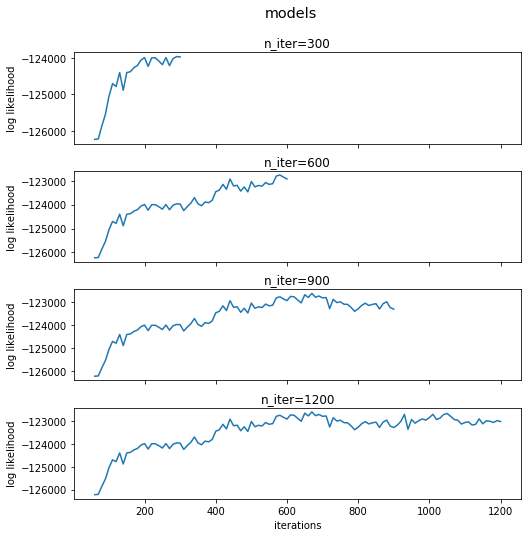

In [22]:
import matplotlib.pyplot as plt

subplots_opts = None
subplots_adjust_opts = None
fig_kwargs = {}
title = 'models'
xaxislabel = 'iterations'
yaxislabel = 'log likelihood'
title_fontsize='x-large'
axes_title_fontsize = 'large'

n_models = len(model_logliks)
figsize = figsize = (8, 2*n_models)

subplots_kwargs = dict(nrows=n_models, ncols=1, sharex=True, constrained_layout=True, figsize=figsize)
subplots_kwargs.update(subplots_opts or {})
subplots_kwargs.update(fig_kwargs)

fig, axes = plt.subplots(**subplots_kwargs)

# set title
if title:
    fig.suptitle(title, fontsize=title_fontsize)

# set adjustments
if title:
    subplots_adjust_kwargs = dict(top=0.9, hspace=0.3)
else:
    subplots_adjust_kwargs = {}

subplots_adjust_kwargs.update(subplots_adjust_opts or {})

if subplots_adjust_kwargs:
    fig.subplots_adjust(**subplots_adjust_kwargs)

for i, (ax, (subplot_lbl, iters, ll)) in enumerate(zip(axes, model_logliks)):
    ax.plot(iters, ll, label=subplot_lbl)
    
    ax.set_title(subplot_lbl, fontsize=axes_title_fontsize)

    # set axis labels
    if xaxislabel and i == n_models-1:
        ax.set_xlabel(xaxislabel)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)

fig.show()